In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import datetime as dt
from datetime import datetime

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)

# Part 2 - Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
query = f'''
    SELECT 
        date,
        AVG(prcp) as avg_prcp
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        date
    ORDER BY 
        date
'''

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.read_sql(query, conn)

# Convert the date column to date
prec_df['date'] = pd.to_datetime(prec_df['date'])

# Sort the dataframe by date
prec_df.sort_values('date')

# Set the index to date
prec_df = prec_df.set_index('date')

In [8]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_df.describe()

,avg_prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [9]:
# Design a query to show how many stations are available in this dataset?

query = '''
    SELECT
        COUNT(station) AS station_count
    FROM
        station
'''

# Save the query results as a Pandas DataFrame and set the index to the date column
session_df = pd.read_sql(query, conn)

station_count = session_df['station_count'].values[0]

station_count

9

In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = '''
    SELECT 
        s.station AS station_code,
        s.name AS station_name
        ,COUNT(*) AS station_count
    FROM 
        measurement m
        INNER JOIN station s 
        ON m.station = s.station
    GROUP BY
        s.station,
        s.name
    ORDER BY
        station_count DESC
'''

active_df = pd.read_sql(query, conn)

active_df.head()

,station_code,station_name,station_count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_df.sort_values('station_count', ascending=False, inplace=True)
most_active_session = active_df['station_code'].values[0]
print(f'The most active session is: {most_active_session}')

query = f'''
    SELECT 
        MIN(tobs) AS lowest_temperature,
        MAX(tobs) AS highest_temperature,
        AVG(tobs) AS average_temperature
    FROM
        measurement
    WHERE
        station = '{most_active_session}'
'''

most_active_session_stats_df = pd.read_sql(query, conn)

most_active_session_stats_df

The most active session is: USC00519281


,lowest_temperature,highest_temperature,average_temperature
0,54.0,85.0,71.663781


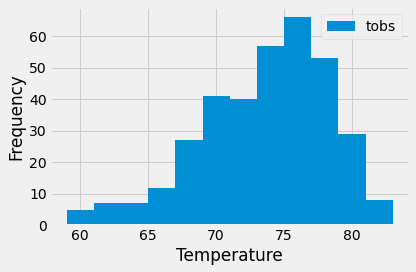

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = f'''
    SELECT 
        tobs
    FROM
        measurement
    WHERE
        station = '{most_active_session}'
        AND date >= (SELECT date((SELECT MAX(date) FROM measurement),'-1 year'))
'''

temp_obs_df = pd.read_sql(query, conn)

temp_obs_df.plot.hist(bins=12)

plt.xlabel("Temperature")
plt.tight_layout()

## Part 3 - Data Analysis Assignment

In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
start_date = datetime.strptime('2012-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2012-01-07', '%Y-%m-%d')
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
    SELECT 
        MIN(tobs),
        MAX(tobs),
        AVG(tobs)
    FROM
        measurement
    WHERE
        date BETWEEN '{start_date}' AND '{end_date}'
    '''

    temp_stats_df = pd.read_sql(query, conn)
    
    temp_stats = temp_stats_df.values[0]
    
    return temp_stats

print(calc_temps(start_date, end_date))

[62.         76.         69.14285714]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


from datetime import datetime
from dateutil.relativedelta import relativedelta

start_date_last_year = start_date + relativedelta(years = -1)
end_date_last_year = end_date + relativedelta(years = -1)

tmin, tmax, tavg = calc_temps(start_date_last_year.strftime("%Y-%m-%d"), end_date_last_year.strftime("%Y-%m-%d"))

print(f'Date range: {start_date_last_year} - {end_date_last_year}')

print(f'''
Min temp: {tmin}
Max temp: {tmax}
Avg Temp: {tavg}
''')

Date range: 2011-01-01 00:00:00 - 2011-01-07 00:00:00

Min temp: 61.0
Max temp: 77.0
Avg Temp: 69.01785714285714



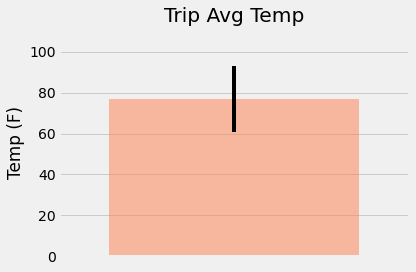

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)

fig.tight_layout()

In [16]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = f'''
    SELECT 
        s.station,
        s.name,
        s.latitude,
        s.longitude,
        s.elevation
        ,sum(m.prcp) AS total_rainfall
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.date BETWEEN '{start_date_last_year}' AND '{end_date_last_year}'
    GROUP BY
        s.name
    ORDER BY
        total_rainfall DESC
'''

results_df = pd.read_sql(query, conn)
results_df


,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.74
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.39
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.32
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.29
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.17
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.17
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.02
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.01
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    query = f'''
        SELECT 
            *
        FROM
            measurement 
    '''

    results_df = pd.read_sql(query, conn)

    results_df['monthday'] = pd.to_datetime(results_df['date']).dt.strftime('%m-%d')

    filtered_df = results_df.loc[results_df['monthday']==date]

    group_df = filtered_df.groupby('monthday')

    group_agg = group_df.agg({'tobs': ['min', 'max', 'mean']})
    
    daily_normals = list(group_agg.values[0])
    
    daily_normals.insert(0, date)
    
    return daily_normals

daily_normals("01-01")

['01-01', 62.0, 77.0, 69.15384615384616]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(daily_normals(date))
    
normals

[['01-01', 62.0, 77.0, 69.15384615384616],
 ['01-02', 60.0, 77.0, 69.39622641509433],
 ['01-03', 62.0, 77.0, 68.9090909090909],
 ['01-04', 58.0, 76.0, 70.0],
 ['01-05', 56.0, 76.0, 67.96428571428571],
 ['01-06', 61.0, 76.0, 68.96491228070175],
 ['01-07', 57.0, 76.0, 68.54385964912281]]

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['date', 'tmin', 'tavg', 'tmax'])
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
01-01,62.0,77.0,69.153846
01-02,60.0,77.0,69.396226
01-03,62.0,77.0,68.909091
01-04,58.0,76.0,70.000000
01-05,56.0,76.0,67.964286


Text(9.310000000000002, 0.5, 'Temperature')

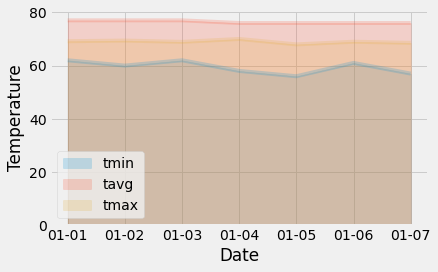

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")
